# **CNN Model predicting a letter from a-z**






#**Setup the environment**


*   Install Gradio for creating interactive UIs.
*   Install a set of specific packages with specified versions.
*   Upgrade TensorFlow to the latest version.
*   Install the EMNIST dataset.


In [32]:
# Install the Gradio library for creating interactive UIs for machine learning models
!pip install gradio

# Install required packages, specifying their versions
%pip install -q typing-extensions==4.5.0 kaleido accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

# Upgrade the TensorFlow library to the latest version
!pip install --upgrade tensorflow

# Install the EMNIST dataset, which is an extension of the MNIST dataset
!pip install emnist

# **Libraries**


*   You import various libraries for handling data, building neural networks, and visualizing results.
*   You use the EMNIST dataset for your machine learning task.
*   TensorFlow and Keras are used for building and training neural networks.
*   Gradio is imported for creating interactive user interfaces.
*   Scikit-learn's metrics and Seaborn are imported for evaluating and visualizing model performance.







In [33]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import emnist
import math
from emnist import extract_test_samples, extract_training_samples
import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import gradio as gr
import seaborn as sn
from keras.utils import to_categorical
from tensorflow.keras.optimizers import legacy

# **Dataset**


*   Load the EMNIST dataset for letters and extract both training and test samples.
*   Visualize a subset of the training data using matplotlib, displaying images along with their corresponding labels. The number of characters to display is set by char_to_display.
*   The visualization is arranged in a square grid with the specified number of cells.





In [4]:
# Load the EMNIST dataset (letters)
emnist_data = emnist.extract_training_samples('letters')

In [48]:
# Define parameters for visualization
x_train, y_train = extract_training_samples('letters')
x_test, y_test = extract_test_samples('letters')

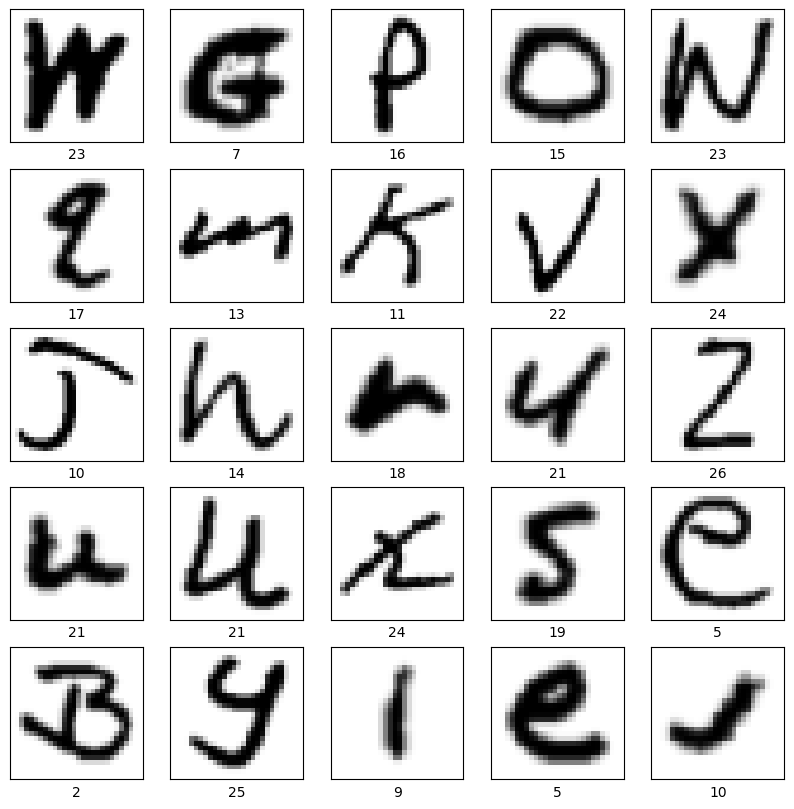

In [49]:
# Visualize a subset of the training data
char_to_display = 25
num_cells = math.ceil(math.sqrt(char_to_display))
plt.figure(figsize=(10,10))
for i in range(char_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

**Define the data**

*   The data is split into training and validation sets.
*   Pixel values are normalized to the range [0, 1].
*   Labels are adjusted to start from 0 and then converted to one-hot encoding.

In [7]:
# Split the data into training and validation sets
split_index = int(0.8 * len(emnist_data[0]))
train_images, train_labels = emnist_data[0][:split_index], emnist_data[1][:split_index]
val_images, val_labels = emnist_data[0][split_index:], emnist_data[1][split_index:]

# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
val_images = val_images / 255.0

# Convert labels to integers (1 to 26, corresponding to 'a' to 'z')
train_labels = train_labels - 1
val_labels = val_labels - 1

# Convert labels to one-hot encoding
train_labels = keras.utils.to_categorical(train_labels, 26)
val_labels = keras.utils.to_categorical(val_labels, 26)

**Apply data augmentation**

*   Data augmentation is applied using the ImageDataGenerator from Keras to artificially increase the diversity of the training dataset. It includes rotation, horizontal and vertical shifts, and horizontal flipping.




In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_images = train_images.reshape(-1, 28, 28, 1)
datagen.fit(train_images)

# **Model**

**Build model**

*   The model consists of convolutional layers for feature extraction, max-pooling layers for down-sampling, and fully connected layers for classification.
*   The model uses the ReLU activation function for convolutional and fully connected layers.
*   Dropout is applied to reduce overfitting.
*   The output layer has 26 units (corresponding to the 26 letters) with softmax activation for multiclass classification.

In [34]:
# Building the Model Architecture
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

**Layers**

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                

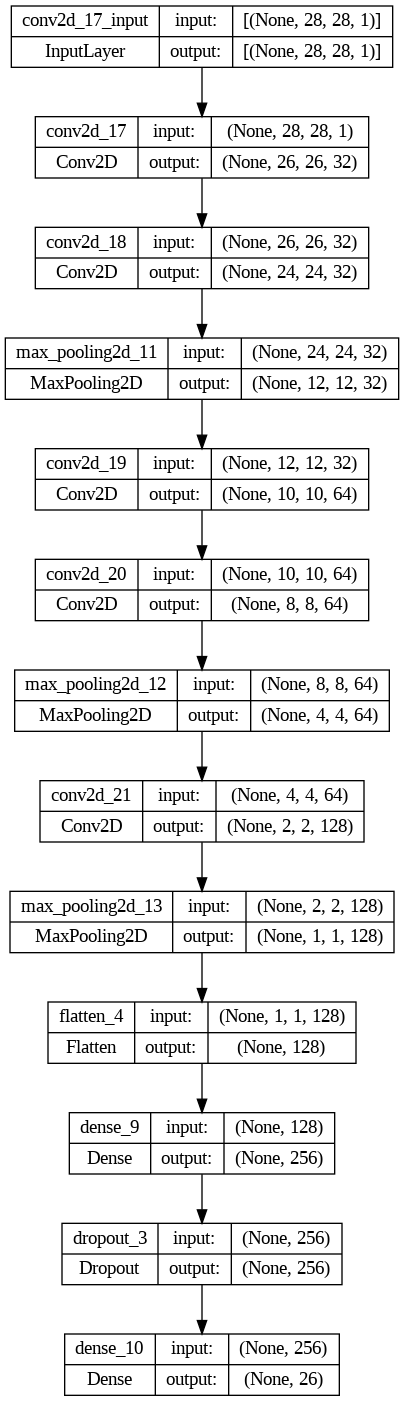

In [36]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [37]:
# Number of layers in the model
print("Number of layers in the model:", len(model.layers))

Number of layers in the model: 12


**FLOPs**

In [38]:
# Convert the model to a TensorFlow graph.
frozen_graph = tf.function(model).get_concrete_function(tf.TensorSpec([1, 28, 28, 1], tf.float32))

# Calculate the FLOPs of the model.
run_meta = tf.compat.v1.RunMetadata()
opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
flops = tf.compat.v1.profiler.profile(graph=frozen_graph.graph, run_meta=run_meta, cmd="scope", options=opts)

# Print the total FLOPs of the model.
print(flops.total_float_ops)

20154396


**Compile the model (adjust learning rate)**

*   The schedule function defines a learning rate schedule. It keeps the learning rate as 0.001 for the first 10 epochs and then exponentially decreases it.
The LearningRateScheduler callback is created using the defined schedule function.
*   The model is compiled using the Adam optimizer, categorical cross-entropy loss (suitable for multiclass classification), and accuracy as the metric to monitor during training.


In [39]:
# Learning Rate Scheduling
def schedule(epoch, lr):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * np.exp(0.1 * (10 - epoch))

lr_schedule = keras.callbacks.LearningRateScheduler(schedule)

# Compile the model with F1 score metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**

*   The log_dir is defined to store TensorBoard logs in a directory named based on the current date and time.
*   The TensorBoard callback is created with the specified log directory and a histogram frequency of 1.
*   The fit method is used to train the model. It takes data from the data generator, specifies the number of steps per epoch, the number of training epochs, validation data, and callbacks for learning rate scheduling and TensorBoard.
*   The verbose parameter is set to 1 to display progress updates during training.






In [40]:
# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Train the model with data augmentation and learning rate scheduling
training_history = model.fit(
                    datagen.flow(train_images, train_labels, batch_size=64),
                    steps_per_epoch=len(train_images) / 64,
                    epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[lr_schedule, tensorboard_callback],
                    verbose=1)

Epoch 1/30
1560/1560 [==============================] - 252s 161ms/step - loss: 1.0208 - accuracy: 0.6744 - val_loss: 0.3941 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 2/30
1560/1560 [==============================] - 243s 156ms/step - loss: 0.4847 - accuracy: 0.8431 - val_loss: 0.3578 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 3/30
1560/1560 [==============================] - 248s 159ms/step - loss: 0.4127 - accuracy: 0.8656 - val_loss: 0.3121 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 4/30
1560/1560 [==============================] - 239s 153ms/step - loss: 0.3721 - accuracy: 0.8783 - val_loss: 0.2802 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 5/30
1560/1560 [==============================] - 220s 141ms/step - loss: 0.3481 - accuracy: 0.8855 - val_loss: 0.2901 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 6/30
1560/1560 [==============================] - 207s 133ms/step - loss: 0.3349 - accuracy: 0.8898 - val_loss: 0.2595 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 7/30
1560/1560 [============

# **Summary graphs**

*   The loss and accuracy data from the training history are extracted.
*   Two subplots are created for combined graphs of loss and accuracy.
*   Each subplot shows both training and validation data, with different colors for better distinction.
*   The title, x-axis label, y-axis label, and legend are set for each subplot.
*   The plt.tight_layout() ensures proper spacing, and plt.show() displays the combined graphs.




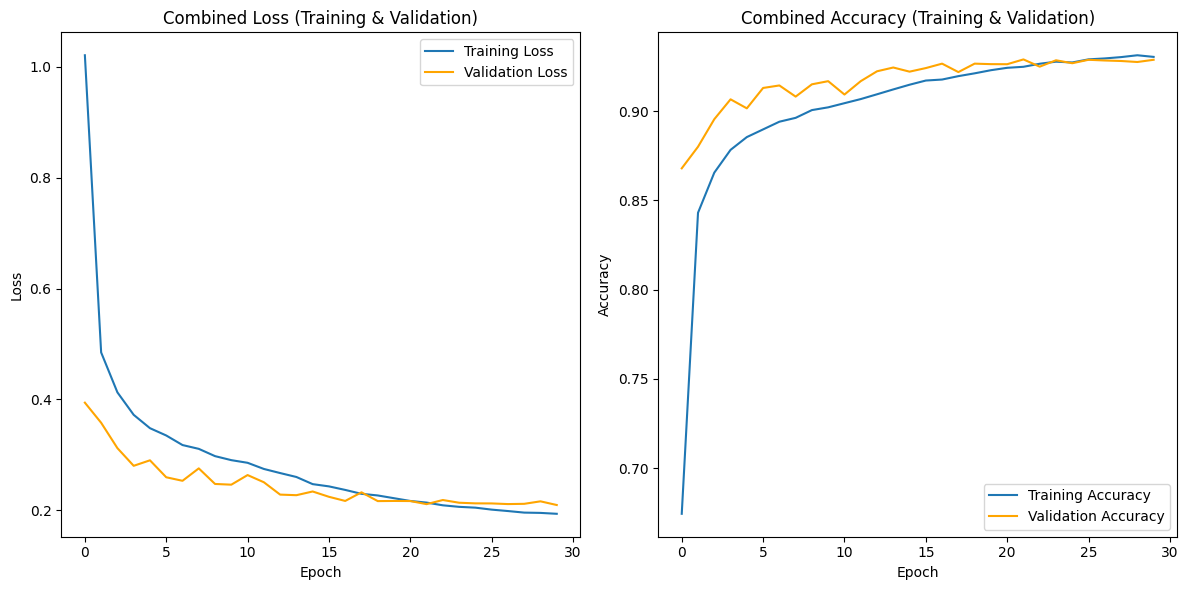

In [41]:
# Extract loss and accuracy data from the training history
loss = training_history.history['loss']
accuracy = training_history.history['accuracy']
val_loss = training_history.history['val_loss']
val_accuracy = training_history.history['val_accuracy']

# Create subplots for two combined graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Combined Loss graph
axes[0].plot(loss, label='Training Loss')
axes[0].plot(val_loss, label='Validation Loss', color='orange')
axes[0].set_title('Combined Loss (Training & Validation)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Combined Accuracy graph
axes[1].plot(accuracy, label='Training Accuracy')
axes[1].plot(val_accuracy, label='Validation Accuracy', color='orange')
axes[1].set_title('Combined Accuracy (Training & Validation)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


*   The code assumes you have the predicted labels (val_predictions) and true labels (val_true_labels) for the validation data.
*   F1 scores are computed at different thresholds by binarizing the predicted labels.
*   The F1 scores are plotted against the threshold values to visualize the performance at different decision boundaries.
*   The plot shows how the F1 score varies with different thresholds, helping to choose an appropriate threshold for classification.


780/780 [==============================] - 12s 16ms/step


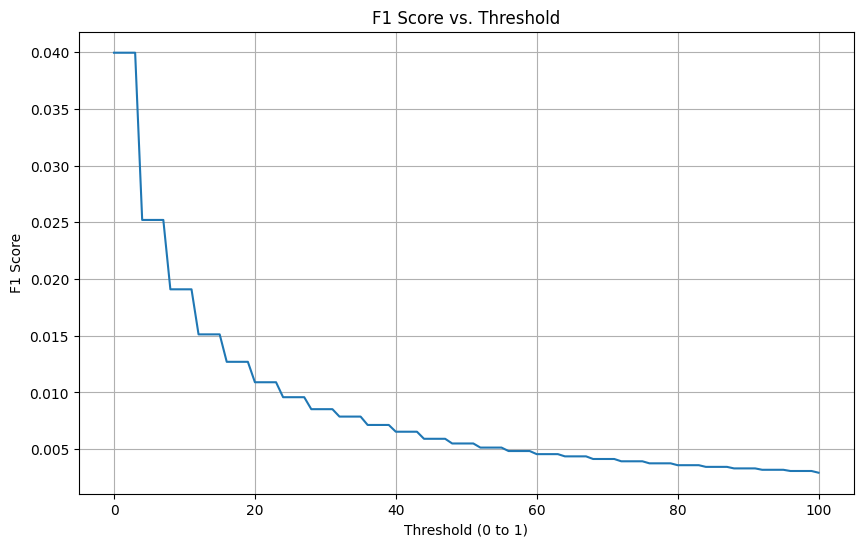

In [42]:
# Assuming you have the predicted and true labels
val_predictions = model.predict(val_images)
val_predictions = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)

f1_scores = []
thresholds = range(0, 101, 1)  # Vary thresholds from 0 to 1

for threshold in thresholds:
    threshold /= 100.0
    binarized_predictions = (val_predictions / 25.0) > threshold
    f1 = f1_score(val_true_labels, binarized_predictions, average='weighted')
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold (0 to 1)')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

780/780 [==============================] - 12s 16ms/step


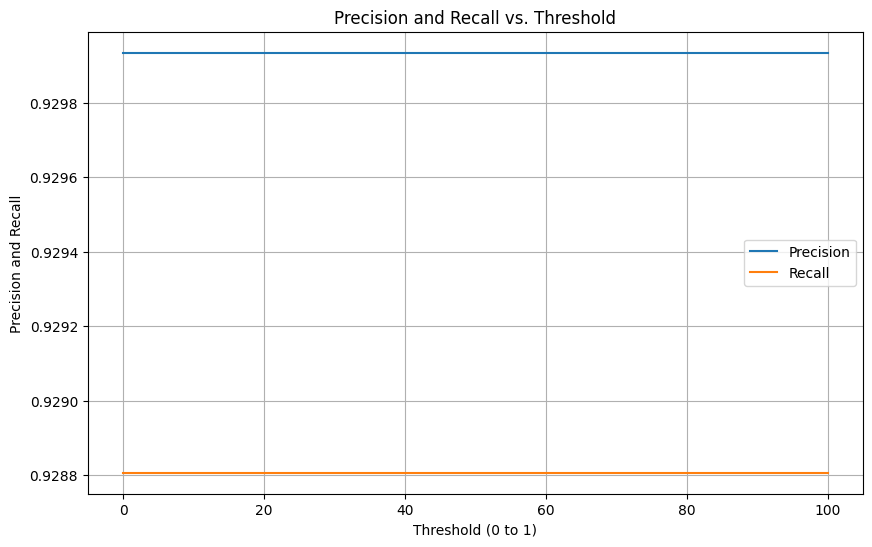

In [43]:
# Make predictions for the validation set
val_predictions = model.predict(val_images)
val_predictions = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(val_true_labels, val_predictions, average='weighted')
recall = recall_score(val_true_labels, val_predictions, average='weighted')
f1 = f1_score(val_true_labels, val_predictions, average='weighted')

# Plot precision and recall against the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, [precision] * len(thresholds), label='Precision')
plt.plot(thresholds, [recall] * len(thresholds), label='Recall')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold (0 to 1)')
plt.ylabel('Precision and Recall')
plt.legend()
plt.grid()
plt.show()

**Evaluate the mode**

In [44]:
# Print evaluation metrics
print(f'Validation Loss: {val_loss[0]:.4f}')
print(f'Validation Accuracy: {val_accuracy[0]:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

Validation Loss: 0.3941
Validation Accuracy: 0.8680
Validation Precision: 0.9299
Validation Recall: 0.9288
Validation F1 Score: 0.9285


In [45]:
model_name = 'models/my_model.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Mistakes**

**Look for the mistakes**

*   The code visualizes a subset of the training data by displaying images along with their predicted labels.
*   The colormap used for each subplot depends on whether the predicted label matches the true label.
*   The images are reshaped and displayed in a grid of subplots with adjusted spacing. The x-axis label of each subplot shows the predicted label.



3120/3120 [==============================] - 50s 16ms/step


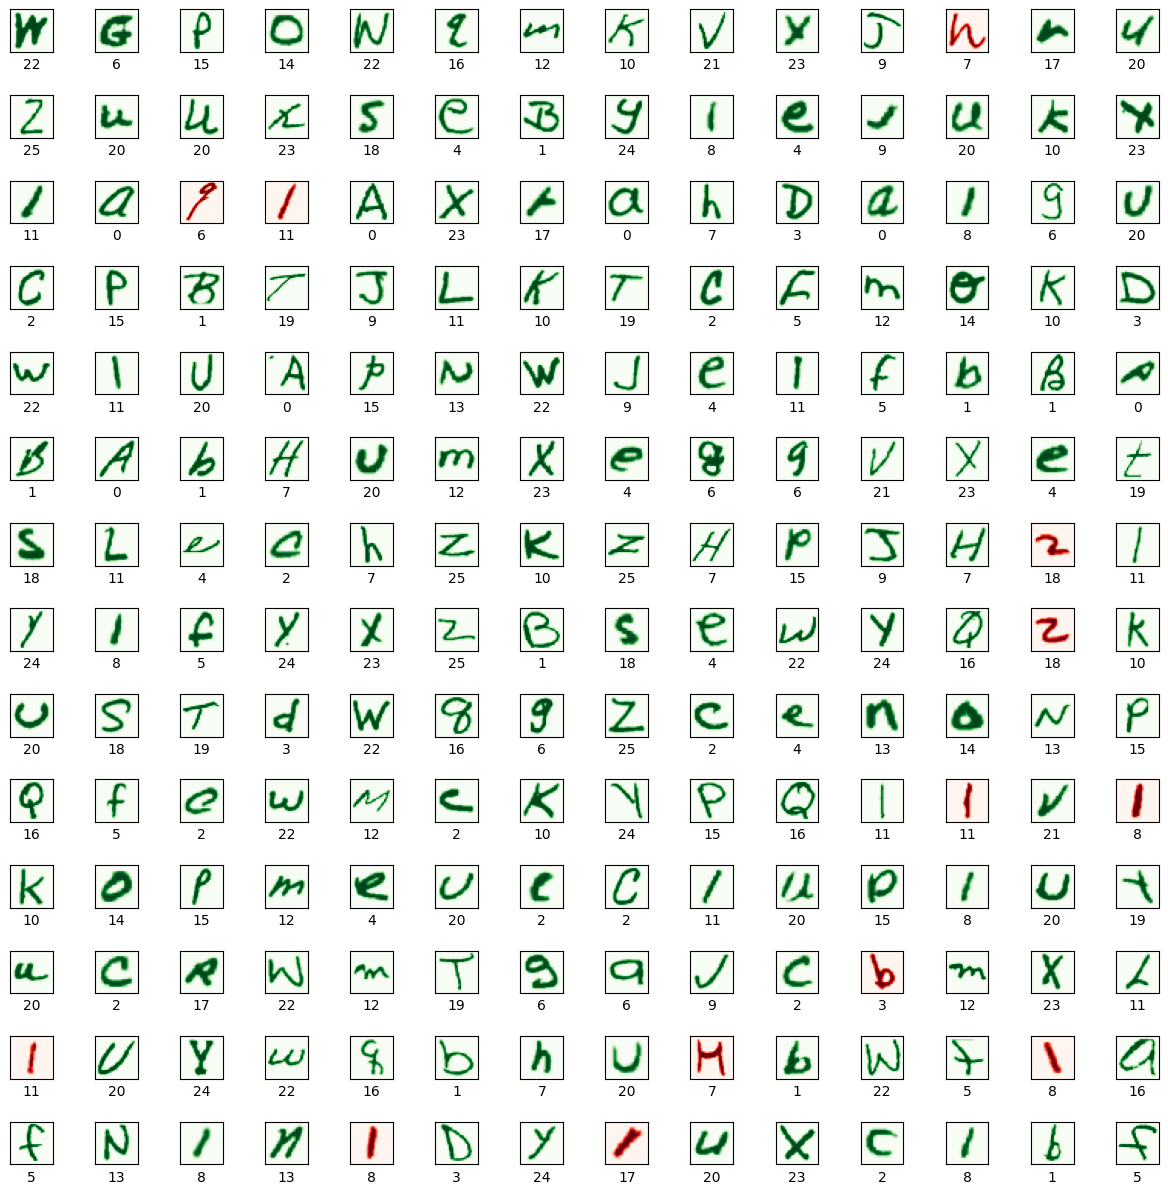

In [46]:
char_to_display = 196
num_cells = math.ceil(math.sqrt(char_to_display))
predictions = model.predict(train_images)  # Use train_images for predictions

# Create a figure with subplots
plt.figure(figsize=(15, 15))
for plot_index in range(char_to_display):
    predicted_label_index = np.argmax(predictions[plot_index])
    true_label_index = np.argmax(train_labels[plot_index])  # Use train_labels

    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    color_map = 'Greens' if predicted_label_index == true_label_index else 'Reds'
    plt.imshow(train_images[plot_index].reshape(28, 28), cmap=color_map)  # Reshape the image
    plt.xlabel(predicted_label_index)

# Adjust subplot spacing
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

**Mistakes distribution**
*   The code makes predictions on the training data using the trained model.
*   True labels and predicted labels are obtained by finding the indices of the maximum values in the one-hot encoded labels and predictions, respectively.
*   A confusion matrix is created using the confusion_matrix function from scikit-learn, comparing the true labels with the predicted labels.
*   The confusion matrix is visualized using a heatmap with Seaborn's heatmap function. The heatmap displays the counts of correct and incorrect predictions for each class. The annot=True parameter adds numeric values to each cell, and square=True ensures a square-shaped heatmap.




3120/3120 [==============================] - 49s 16ms/step


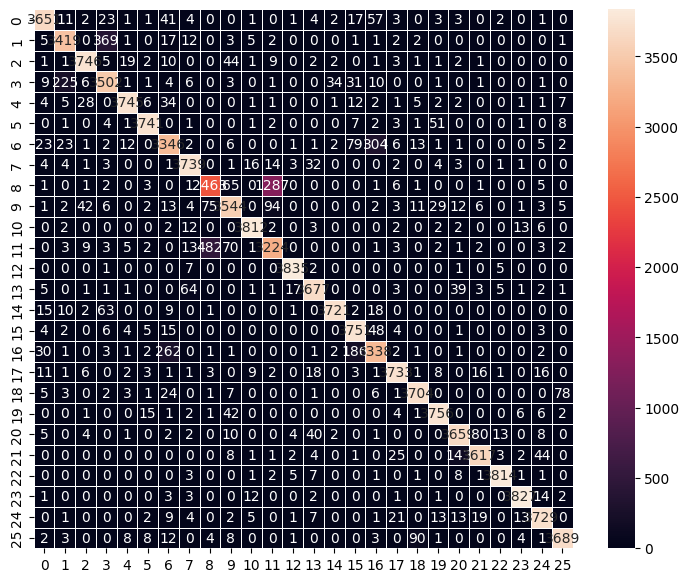

In [47]:
# Make predictions on the training data
predictions = model.predict(train_images)

# Get the true labels as indices
true_labels = np.argmax(train_labels, axis=1)

# Get the predicted labels as indices
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
confusion_matrix = confusion_matrix(true_labels, predicted_labels)

# Create the heatmap
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

# **Gradio sketchpad**

In [50]:
# Load your pre-trained CNN model
model = keras.models.load_model(model_name)

# Define a function to predict a letter
def predict_letter(letter_image):
    # Preprocess the drawn letter
    letter_image = np.array(letter_image).astype(float)
    letter_image = letter_image / 255.0  # Normalize pixel values to [0, 1]
    letter_image = letter_image.reshape(1, 28, 28, 1)  # Reshape to match the CNN input shape (28x28x1)

    # Make a prediction using the CNN model
    prediction = model.predict(letter_image)

    # Get the predicted letter
    predicted_letter = chr(ord('a') + np.argmax(prediction))

    return predicted_letter

# Create a Gradio interface with a larger sketchpad and custom CSS
css = """
<style>
  .gr-input.sketchpad {
    width: 400px;
    height: 400px;
  }
</style>
"""

iface = gr.Interface(
    fn=predict_letter,
    inputs="sketchpad",
    outputs="text",
    live=True,
    title="CNN-Based Letter Recognition",
    description="Draw a letter (a-z) and let the model predict it.",
    css=css  # Include the custom CSS here
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://fd2a7c07ce07ffcc02.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
